In [1]:
import warnings
warnings.filterwarnings('ignore')

In [398]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Anubhav@7390',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = '/Users/anubhavshukla/Downloads/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [7]:
connection = mysql.connector.connect(host = "localhost", port = 3306, user = "root", password = "Anubhav@7390", database = "ecommerce")

In [9]:
df = pd.read_sql_query("select * from customers", connection)

In [11]:
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
397759,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
397760,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
397761,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
397762,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


### 1. List all unique cities where customers are located.


In [15]:
df = pd.read_sql_query("select distinct customer_city from customers", connection)
df

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


### 2. Count the number of orders placed in 2017.


In [18]:
df = pd.read_sql_query("select count(*) as total_orders_placed_in_2017 from orders where year(order_purchase_timestamp) = 2017", connection)
df

,total_orders_placed_in_2017
0,180404


#### 3. Find the total sales per category.


In [21]:
df = pd.read_sql_query("select upper(pr.product_category) as Category, round(sum(py.payment_value),2) as total_sales from products pr join order_items o using(product_id) join payments py using(order_id) group by pr.product_category", connection)
df

,Category,total_sales
0,PERFUMERY,3.243127e+07
1,FURNITURE DECORATION,9.153129e+07
2,TELEPHONY,3.116045e+07
3,BED TABLE BATH,1.096034e+08
4,AUTOMOTIVE,5.454684e+07
...,...,...
69,CDS MUSIC DVDS,7.676352e+04
70,LA CUISINE,1.864659e+05
71,FASHION CHILDREN'S CLOTHING,5.028288e+04
72,PC GAMER,1.391635e+05


### 4. Calculate the percentage of orders that were paid in installments.


In [23]:
df = pd.read_sql_query("select (sum(case when payment_installments >=1 then 1 else 0 end) / count(*)) * 100  as orders_paid_in_installments from payments", connection)
df

,orders_paid_in_installments
0,99.9981


### 5. Count the number of customers from each state. 


In [25]:
df = pd.read_sql_query("select customer_state ,count(customer_unique_id) as number_of_customers from customers group by customer_state order by number_of_customers desc", connection)
df

,customer_state,number_of_customers
0,SP,166984
1,RJ,51408
2,MG,46540
3,RS,21864
4,PR,20180
5,SC,14548
6,BA,13520
7,DF,8560
8,ES,8132
9,GO,8080


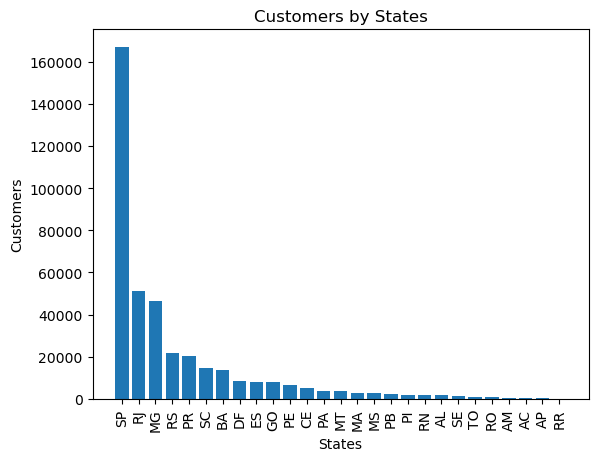

<Figure size 800x300 with 0 Axes>

In [26]:
plt.bar(df["customer_state"], df["number_of_customers"])
plt.title("Customers by States")
plt.xlabel("States")
plt.ylabel("Customers")
plt.xticks(rotation = 90)
plt.figure(figsize = (8,3))

plt.show()


### 6. Calculate the number of orders per month in 2018.

In [28]:
df = pd.read_sql_query("select monthname(order_purchase_timestamp) as Months,count(order_id) as Orders from orders where year(order_purchase_timestamp) = 2018 group by Months", connection)
df

,Months,Orders
0,July,25168
1,August,26048
2,February,26912
3,June,24668
4,March,28844
5,January,29076
6,May,27492
7,April,27756
8,September,64
9,October,16


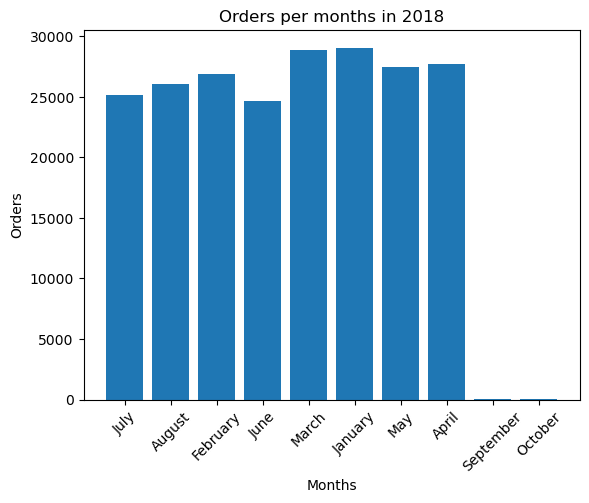

In [29]:
plt.bar(df["Months"], df["Orders"])
plt.title("Orders per months in 2018")
plt.xlabel("Months")
plt.ylabel("Orders")
plt.xticks(rotation =45)
plt.show()

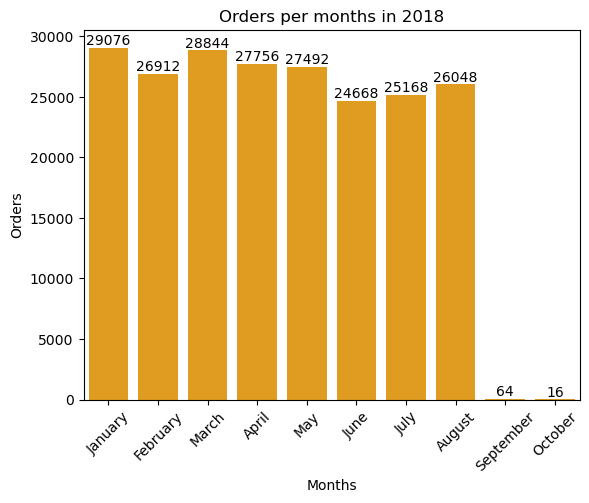

In [30]:
# to order the months i've used seaborn.

o = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August','September','October']
ax = sns.barplot(x = df["Months"], y = df["Orders"], data = df, order = o, color = 'orange')
plt.title("Orders per months in 2018")
plt.xlabel("Months")
plt.ylabel("Orders")
plt.xticks(rotation =45)
ax.bar_label(ax.containers[0])
plt.show()

### 7. Find the average number of products per order, grouped by customer city.


In [32]:
df = pd.read_sql_query("with count_per_order as (select o.order_id, o.customer_id, count(oi.order_id) as co from orders o join order_items oi on o.order_id = oi.order_id group by o.order_id, o.customer_id) select c.customer_city, round(avg(count_per_order.co),2) as average_orders from customers c join count_per_order on c.customer_id = count_per_order.customer_id group by c.customer_city order by average_orders desc", connection)

df


,customer_city,average_orders
0,padre carvalho,112.0
1,celso ramos,104.0
2,datas,96.0
3,candido godoi,96.0
4,matias olimpio,80.0
...,...,...
4105,sao mamede,16.0
4106,sambaiba,16.0
4107,japaratuba,16.0
4108,tuiuti,16.0


### 8. Calculate the percentage of total revenue contributed by each product category.

In [34]:
df = pd.read_sql_query("select upper(pr.product_category) as Category, round((sum(py.payment_value) / (select sum(payment_value) from payments)) * 100, 2)as total_sales_percentage from products pr join order_items oi on pr.product_id = oi.product_id join payments py on oi.order_id = py.order_id group by pr.product_category order by total_sales_percentage desc", connection)

df


,Category,total_sales_percentage
0,BED TABLE BATH,171.16
1,HEALTH BEAUTY,165.65
2,COMPUTER ACCESSORIES,158.45
3,FURNITURE DECORATION,142.94
4,WATCHES PRESENT,142.84
...,...,...
69,PC GAMER,0.22
70,HOUSE COMFORT 2,0.17
71,CDS MUSIC DVDS,0.12
72,FASHION CHILDREN'S CLOTHING,0.08


### 9. Identify the correlation between product price and the number of times a product has been purchased.

In [36]:
df = pd.read_sql_query("select pr.product_category, count(oi.product_id) as count_product, round(avg(oi.price),2) as product_price from products pr join order_items oi on pr.product_id = oi.product_id group by pr.product_category order by count_product desc", connection)

df

,product_category,count_product,product_price
0,bed table bath,177840,93.30
1,HEALTH BEAUTY,154720,130.16
2,sport leisure,138256,114.34
3,Furniture Decoration,133344,87.56
4,computer accessories,125232,116.51
...,...,...,...
69,La Cuisine,224,146.78
70,cds music dvds,224,52.14
71,PC Gamer,144,171.77
72,Fashion Children's Clothing,128,71.23


In [37]:
arr1 = df['count_product']
arr2 = df['product_price']

np.corrcoef(arr1, arr2)

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

it is a nutral relationship between product price and the number of times a product has been purchased.¶

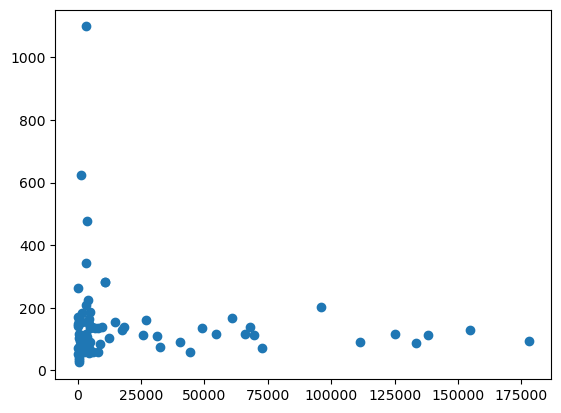

In [39]:
# to show correlation visually.

plt.scatter(df['count_product'], df['product_price'])
plt.show()

#### 10. Calculate the total revenue generated by each seller, and rank them by revenue.

In [41]:
df = pd.read_sql_query("select * , dense_rank() over (order by total_revenue desc) as Rn from (select s.seller_id, round(sum(py.payment_value),2) as total_revenue from sellers s  join order_items oi on s.seller_id = oi.seller_id join payments py on oi.order_id = py.order_id group by seller_id) as a", connection)

df


,seller_id,total_revenue,Rn
0,7c67e1448b00f6e969d365cea6b010ab,32458682.07,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,19726210.55,2
2,4a3ca9315b744ce9f8e9374361493884,19279697.26,3
3,1f50f920176fa81dab994f9023523100,18576218.89,4
4,53243585a1d6dc2643021fd1853d8905,18233797.15,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,1229.44,3076
3091,702835e4b785b67a084280efca355756,1187.84,3077
3092,4965a7002cca77301c82d3f91b82e1a9,1047.04,3078
3093,77128dec4bec4878c37ab7d6169d6f26,974.08,3079


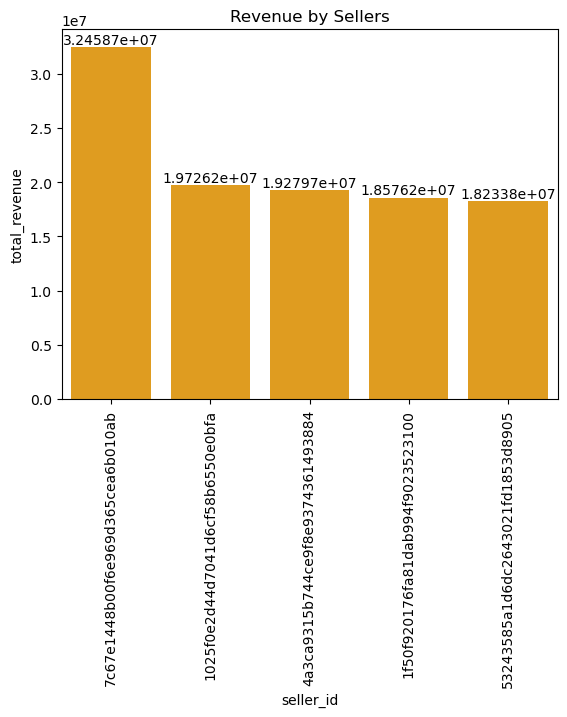

In [42]:
df = df.head()
ax = sns.barplot(x = "seller_id", y = "total_revenue", data = df, color = "orange")
plt.title("Revenue by Sellers")
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.show()

### 11. Calculate the moving average of order values for each customer over their order history.

In [ ]:
df = pd.read_sql_query("select customer_id, order_purchase_timestamp, payment, avg(payment) over (partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as moving_average from (select o.customer_id, o.order_purchase_timestamp, py.payment_value as payment from orders o join payments py on o.order_id = py.order_id) as a", connection)

df

### 12. Calculate the cumulative sales per month for each year.


In [ ]:
df = pd.read_sql_query("select ord_year, ord_month, payment, sum(payment) over (order by ord_year ,ord_month) as cumulative_sales from (select year(o.order_purchase_timestamp) as ord_year, month(o.order_purchase_timestamp) as ord_month, round(sum(py.payment_value),2) as payment from orders o join payments py on o.order_id = py.order_id group by ord_year, ord_month order by ord_year, ord_month) as a", connection)

df

In [ ]:
plt.plot(df["ord_year"], df["cumulative_sales"] , 'orange', marker = "o" )
plt.xticks(rotation = 45)
plt.show()

### 13. Calculate the year-over-year growth rate of total sales.


In [ ]:
df =pd.read_sql_query("with cte as (select year(o.order_purchase_timestamp) as years, round(sum(payment_value),2) as sales from orders o join payments py on o.order_id = py.order_id group by years order by years) select years, round(((sales - lag(sales, 1) over (order by years)) / lag(sales, 1) over (order by years)) * 100,3) as YOY_percentage_growth from cte" , connection)

df


### 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [ ]:
df = pd.read_sql_query("with a as (select customers.customer_id, min(orders.order_purchase_timestamp) first_order from customers join orders on customers.customer_id = orders.customer_id group by customers.customer_id), b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order from a join orders on orders.customer_id = a.customer_id and orders.order_purchase_timestamp > first_order and orders.order_purchase_timestamp <  date_add(first_order, interval 6 month) group by a.customer_id)  select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) as Retention_rate from a left join b  on a.customer_id = b.customer_id;", connection)

df

### 15. Identify the top 3 customers who spent the most money in each year.


In [ ]:
df = pd.read_sql_query("with cte as (select year(o.order_purchase_timestamp) as years, o.customer_id, round(sum(py.payment_value), 3) as money_spent, dense_rank() over (partition by year(o.order_purchase_timestamp) order by sum(py.payment_value) desc) as d_rank from customers c  join orders o on c.customer_id = o.customer_id join payments py on o.order_id = py.order_id group by years , o.customer_id) select years, customer_id, money_spent from cte where d_rank < 4", connection)

df

In [ ]:
sns.barplot(x= "customer_id", y= "money_spent", data= df, hue = "years")
plt.xticks(rotation = 90)
plt.show()